In [1]:
pwd

'/Users/millicentomondi/Documents/XAI_GROUP/lime3'

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms, models
import os
import torch.nn.functional as F
from sklearn.model_selection import train_test_split
import shutil
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt

# reading lime_image
from lime import lime_image
from skimage.segmentation import mark_boundaries 

In [3]:
# Define paths
data_dir = '/Users/millicentomondi/Documents/XAI_GROUP/lime3/flowers'
train_dir = '/Users/millicentomondi/Documents/XAI_GROUP/lime3/train'
val_dir = '/Users/millicentomondi/Documents/XAI_GROUP/lime3/val'

# # Create train and validation directories
# os.makedirs(train_dir, exist_ok=True)
# os.makedirs(val_dir, exist_ok=True)

# # Get the list of classes (subfolders in the data_dir)
# classes = [d for d in os.listdir(data_dir) if os.path.isdir(os.path.join(data_dir, d))]

# for cls in classes:
#     # Create class subdirectories in train and validation directories
#     os.makedirs(os.path.join(train_dir, cls), exist_ok=True)
#     os.makedirs(os.path.join(val_dir, cls), exist_ok=True)

#     # Get the list of image files for the current class
#     cls_dir = os.path.join(data_dir, cls)
#     images = [f for f in os.listdir(cls_dir) if os.path.isfile(os.path.join(cls_dir, f))]

#     # Check if there are images to split
#     if len(images) == 0:
#         print(f"No images found for class {cls}. Skipping...")
#         continue

#     # Split the images into train and validation sets
#     train_images, val_images = train_test_split(images, test_size=0.2, random_state=42)

#     # Move images to the respective directories
#     for img in train_images:
#         shutil.move(os.path.join(cls_dir, img), os.path.join(train_dir, cls, img))
#     for img in val_images:
#         shutil.move(os.path.join(cls_dir, img), os.path.join(val_dir, cls, img))

# print("Dataset split into train and validation folders successfully.")


In [4]:
print(data_dir)

/Users/millicentomondi/Documents/XAI_GROUP/lime3/flowers


In [5]:
# Define data transformations for data augmentation and normalization
data_transforms = {
    'train': transforms.Compose([
        #transforms.RandomResizedCrop(224),
        transforms.Resize((299, 299)),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        #transforms.Resize(256),
        transforms.Resize((299, 299)),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

In [6]:
# Define the data directory
data_dir = '/Users/millicentomondi/Documents/XAI_GROUP/lime3'

# Create data loaders
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x), data_transforms[x]) for x in ['train', 'val']}


In [7]:
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=16, shuffle=True, num_workers=4) for x in ['train', 'val']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
print(dataset_sizes)

class_names = image_datasets['train'].classes
class_names

{'train': 12586, 'val': 3154}


['astilbe',
 'bellflower',
 'black_eyed_susan',
 'calendula',
 'california_poppy',
 'carnation',
 'common_daisy',
 'coreopsis',
 'daffodil',
 'dandelion',
 'iris',
 'magnolia',
 'rose',
 'sunflower',
 'tulip',
 'water_lily']

# Define the model

In [9]:
model = models.inception_v3(pretrained=True)
# Modify the final layer
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, len(class_names))

# Define the loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)  # Use all parameters


# Move the model to the GPU if available
#device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device = torch.device('mps')
model = model.to(device)

# Training the model

In [10]:
# Training loop
num_epochs = 5
for epoch in range(num_epochs):
    for phase in ['train', 'val']:
        if phase == 'train':
            model.train()
        else:
            model.eval()

        running_loss = 0.0
        running_corrects = 0

        for inputs, labels in dataloaders[phase]:
            inputs = inputs.to(device)
            labels = labels.to(device)
            
            # Zero the parameter gradients
            optimizer.zero_grad()

            with torch.set_grad_enabled(phase == 'train'):
                outputs = model(inputs)
                # Inception v3 returns two outputs if training, main and auxiliary
                if isinstance(outputs, tuple):
                    outputs, aux_outputs = outputs
                _, preds = torch.max(outputs, 1)
                loss = criterion(outputs, labels)
                if phase == 'train':
                    loss += 0.4 * criterion(aux_outputs, labels)  # Auxiliary loss (if training)
                
                # Backward pass
                if phase == 'train':
                    loss.backward()
                    optimizer.step()

            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels.data)

        epoch_loss = running_loss / dataset_sizes[phase]
        epoch_acc = running_corrects.float() / dataset_sizes[phase]

        print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

print("Training complete!")

train Loss: 1.0621 Acc: 0.7920
val Loss: 0.2583 Acc: 0.9249
train Loss: 0.3038 Acc: 0.9345
val Loss: 0.2605 Acc: 0.9325
train Loss: 0.1849 Acc: 0.9605
val Loss: 0.2520 Acc: 0.9366
train Loss: 0.1226 Acc: 0.9751
val Loss: 0.2620 Acc: 0.9413
train Loss: 0.0846 Acc: 0.9823
val Loss: 0.2548 Acc: 0.9417
Training complete!


## Saving the model

In [11]:

# Save the model
torch.save(model.state_dict(), 'InceptioN_flower_classification_model.pth')


# Classification on Unseen Image

In [12]:
# Load the saved model
model = models.inception_v3(pretrained=True)
model.fc = nn.Linear(model.fc.in_features, 16)  # Adjust to match the original model's output units
model.load_state_dict(torch.load('InceptioN_flower_classification_model.pth'))
model.eval()

Inception3(
  (Conv2d_1a_3x3): BasicConv2d(
    (conv): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), bias=False)
    (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_2a_3x3): BasicConv2d(
    (conv): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_2b_3x3): BasicConv2d(
    (conv): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (maxpool1): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  (Conv2d_3b_1x1): BasicConv2d(
    (conv): Conv2d(64, 80, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(80, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_4a_3x3): BasicConv2d(
    (conv): Conv2d(80, 192, kernel_size=(3, 3), stri

In [13]:
# Load and preprocess the unseen image
image_path = '/Users/millicentomondi/Documents/XAI_GROUP/flower_images/tulip/1c8f7ee1bb.jpg'  # Replace with the path to your image
image = Image.open(image_path)
preprocess = transforms.Compose([
    transforms.Resize((299, 299)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])
input_tensor = preprocess(image)
input_batch = input_tensor.unsqueeze(0)  # Add a batch dimension


## Inference Using the model

In [14]:
# Perform inference
with torch.no_grad():
    output = model(input_batch)

# Get the predicted class
_, predicted_class = output.max(1)

# Map the predicted class to the class name
class_names = ['astilbe',
 'bellflower',
 'black_eyed_susan',
 'calendula',
 'california_poppy',
 'carnation',
 'common_daisy',
 'coreopsis',
 'daffodil',
 'dandelion',
 'iris',
 'magnolia',
 'rose',
 'sunflower',
 'tulip',
 'water_lily']  # Make sure these class names match your training data
predicted_class_name = class_names[predicted_class.item()]

print(f'The predicted class is: {predicted_class_name}')


The predicted class is: tulip


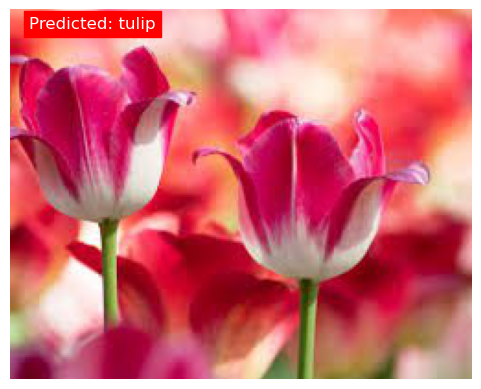

In [15]:
# Display the image with the predicted class name
image = np.array(image)
plt.imshow(image)
plt.axis('off')
plt.text(10, 10, f'Predicted: {predicted_class_name}', fontsize=12, color='white', backgroundcolor='red')
plt.show()

# LIME 

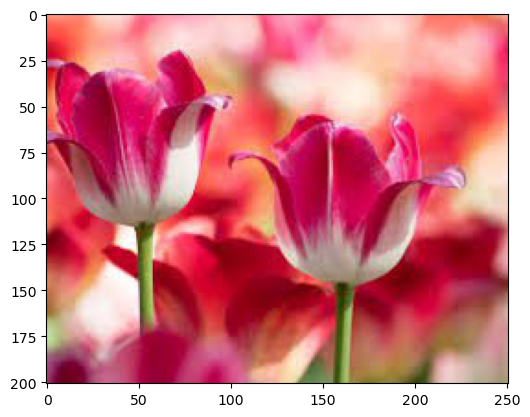

In [51]:
img_file_name = '/Users/millicentomondi/Documents/XAI_GROUP/flower_images/tulip/1c8f7ee1bb.jpg'
img_pil_0 = Image.open(os.path.join("../data",img_file_name)).convert('RGB')

_ = plt.imshow(img_pil_0)

In [45]:
# Load the saved weights
model.load_state_dict(torch.load('InceptioN_flower_classification_model.pth', map_location=device))
model = model.to(device)
model.eval()  # Set the model to evaluation mode

Inception3(
  (Conv2d_1a_3x3): BasicConv2d(
    (conv): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), bias=False)
    (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_2a_3x3): BasicConv2d(
    (conv): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_2b_3x3): BasicConv2d(
    (conv): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (maxpool1): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  (Conv2d_3b_1x1): BasicConv2d(
    (conv): Conv2d(64, 80, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(80, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_4a_3x3): BasicConv2d(
    (conv): Conv2d(80, 192, kernel_size=(3, 3), stri

In [46]:
def cnn_predict(model, images):
    # Transformation for input images
    transf = transforms.Compose([
        transforms.Resize((299, 299)),  # Ensure the input size matches InceptionV3's expected input size
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406],
                             std=[0.229, 0.224, 0.225])
    ])
    
    # Ensure images is a list
    if not isinstance(images, list):
        images = [images]
    
    # Apply transformations and stack into a batch
    batch = torch.stack([transf(img) for img in images], dim=0)
    batch = batch.to(device)  # Move to device (CPU or GPU)

    # Run the model on the input batch
    model.eval()
    with torch.no_grad():
        logits = model(batch)

    # Calculate probabilities
    probs = torch.nn.functional.softmax(logits, dim=1)
    return probs.detach().cpu().numpy()

In [47]:
def plot_explanations(img_pil, explanation):
    fig, axes = plt.subplots(1, 3, figsize=(20, 10))

    axes[0].imshow(img_pil)
    axes[0].axis('off')
    axes[0].set_title("Original Image")

    temp, mask = explanation.get_image_and_mask(explanation.top_labels[0], 
                                                positive_only=True, 
                                                negative_only=False, 
                                                num_features=5, 
                                                hide_rest=True)

    img_boundry = mark_boundaries(temp / 255.0, mask)
    axes[1].imshow(img_boundry)
    axes[1].set_title("Positive mask")
    axes[1].axis('off')

    temp, mask = explanation.get_image_and_mask(explanation.top_labels[0], 
                                                positive_only=False, 
                                                negative_only=True, 
                                                num_features=5, 
                                                hide_rest=True)

    img_boundry = mark_boundaries(temp / 255.0, mask)
    axes[2].imshow(img_boundry)
    axes[2].set_title("Negative mask")
    axes[2].axis('off')

    plt.show()

In [52]:
# Example usage:
# Load an example image
img_path = '/Users/millicentomondi/Documents/XAI_GROUP/flower_images/tulip/1c8f7ee1bb.jpg'
img = Image.open(img_path)

# Perform prediction
probs = cnn_predict(model, img)

# Print the top 5 results
class_names = [
    'astilbe', 'bellflower', 'black_eyed_susan', 'calendula', 'california_poppy',
    'carnation', 'common_daisy', 'coreopsis', 'daffodil', 'dandelion',
    'iris', 'magnolia', 'rose', 'sunflower', 'tulip', 'water_lily'
]

top5_probs, top5_classes = torch.topk(torch.tensor(probs[0]), 5)
top5_results = [(class_names[idx], prob.item()) for idx, prob in zip(top5_classes, top5_probs)]

print("Top 5 Results:", top5_results)

Top 5 Results: [('tulip', 0.9999247789382935), ('california_poppy', 1.7963326172321104e-05), ('rose', 1.6221130863414146e-05), ('carnation', 1.1404483302612789e-05), ('magnolia', 9.413720363227185e-06)]


In [53]:
# LIME explainer
explainer = lime_image.LimeImageExplainer()
explanation = explainer.explain_instance(np.array(img), 
                                         lambda x: cnn_predict(model, [Image.fromarray(xi) for xi in x]),  # classification function
                                         top_labels=2, 
                                         hide_color=0, 
                                         num_samples=1000)



  0%|          | 0/1000 [00:00<?, ?it/s]

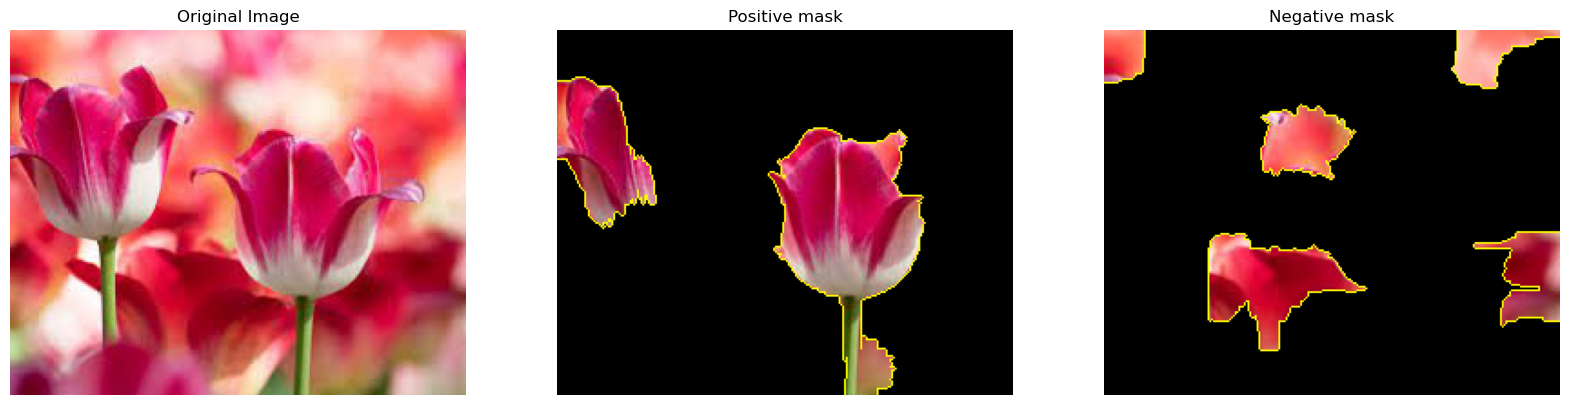

In [54]:

# Plot explanations
plot_explanations(img, explanation)